In [ ]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/MovieRecommendation")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_samples, silhouette_score

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import movies
movies = pd.read_csv('/content/drive/MyDrive/MovieRecommendation/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# Import ratings
ratings = pd.read_csv('/content/drive/MyDrive/MovieRecommendation/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Now that we know the structure of our dataset, how many records do we have in each of these tables?

In [ ]:
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100004  ratings of  9125  movies.


## Romance vs. Scifi

In [ ]:
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings

# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
1,3.50,2.40
2,3.59,3.80
3,3.65,3.14
4,4.50,4.26
5,4.08,4.00


The function `get_genre_ratings` calculates each user's average rating of all romance movies and all scifi movies. 

In [ ]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  183


,index,avg_romance_rating,avg_scifi_rating
0,1,3.50,2.40
1,3,3.65,3.14
2,6,2.90,2.75
3,7,2.93,3.36
4,12,2.89,2.62


So we can see we have 183 users, and for each user we have their average rating of the romance and sci movies they've watched.

Let us plot this dataset:

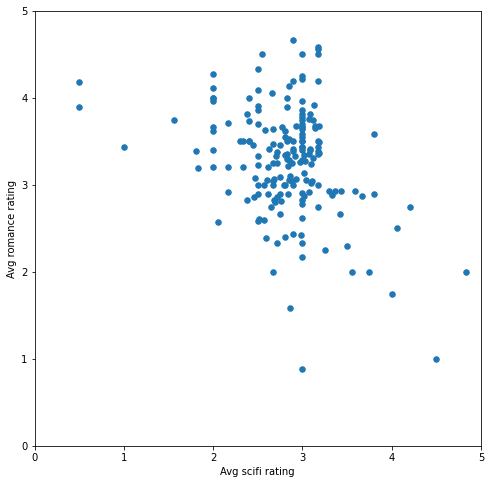

In [ ]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)
    
# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

In [ ]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

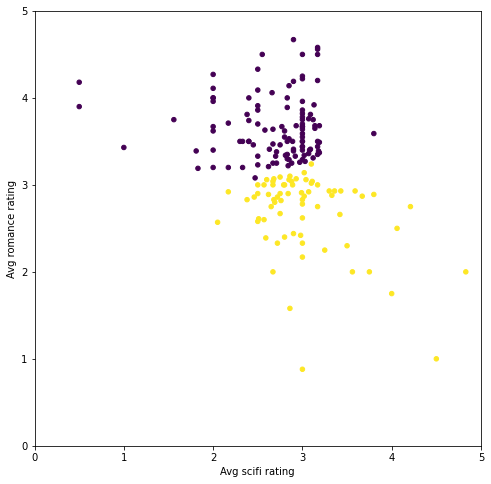

In [ ]:
# Import KMeans
from sklearn.cluster import KMeans

# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

# Plot
draw_clusters(biased_dataset, predictions)

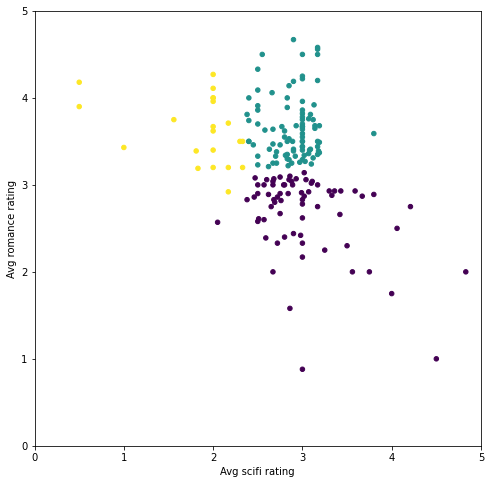

In [ ]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)

# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)

# Plot
draw_clusters(biased_dataset, predictions_2)

Now the average scifi rating is starting to come into play. The groups are:
 * people who like romance but not scifi
 * people who like scifi but not romance
 * people who like both scifi and romance
 

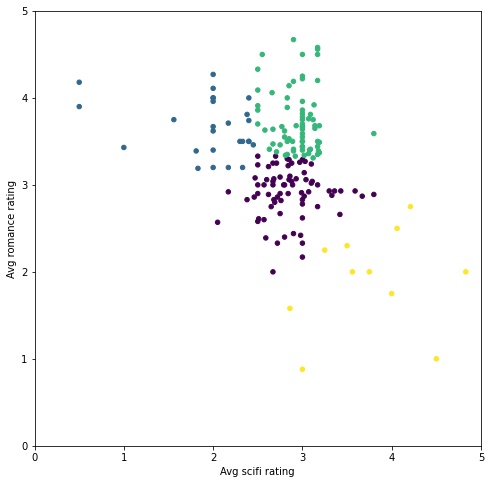

In [ ]:
# Create an instance of KMeans to find three clusters
kmeans_3 = KMeans(n_clusters=4)

# Use fit_predict to cluster the dataset
predictions_3 = kmeans_3.fit_predict(X)

# Plot
draw_clusters(biased_dataset, predictions_3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: ConvergenceWarning: Number of distinct clusters (178) found smaller than n_clusters (182). Possibly due to duplicate points in X.
  


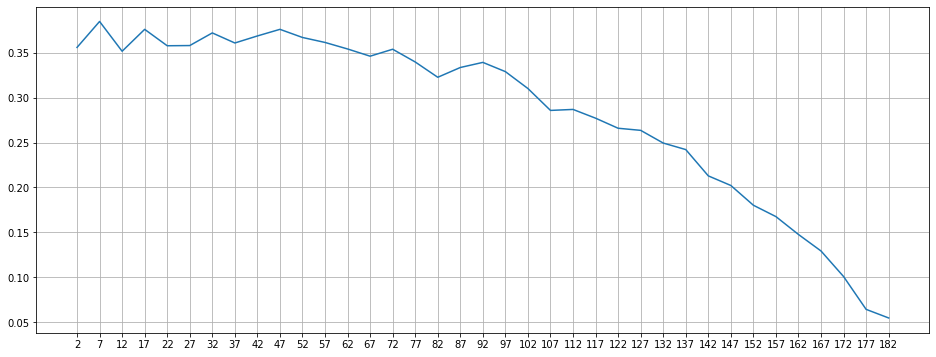

In [ ]:
# Selecting our dataset to study
df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]

# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)

# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

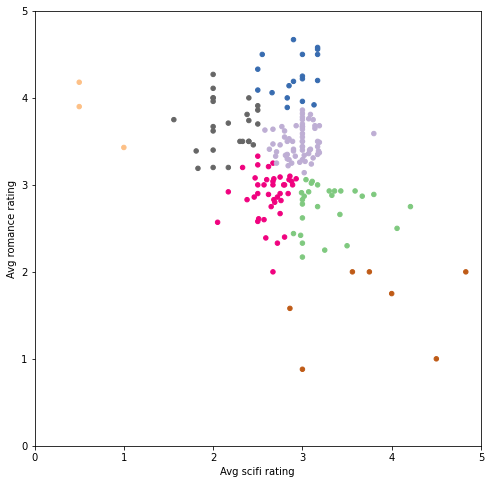

In [ ]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)

# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)

# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

In [ ]:
# Select our biased dataset and add action genre
biased_dataset_3_genres = get_genre_ratings(ratings, movies, ['Romance','Sci-Fi', 'Action'],                                          
['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])

# Drop null values
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()

# Print the number of records and the head of our dataset
print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()


Number of records:  183


,index,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,1,3.50,2.40,2.80
1,3,3.65,3.14,3.47
2,6,2.90,2.75,3.27
3,7,2.93,3.36,3.29
4,12,2.89,2.62,3.21


In [ ]:
# Add action ratings
X_with_action = biased_dataset_3_genres[['avg_scifi_rating',
                                         'avg_romance_rating', 
                                         'avg_action_rating']].values

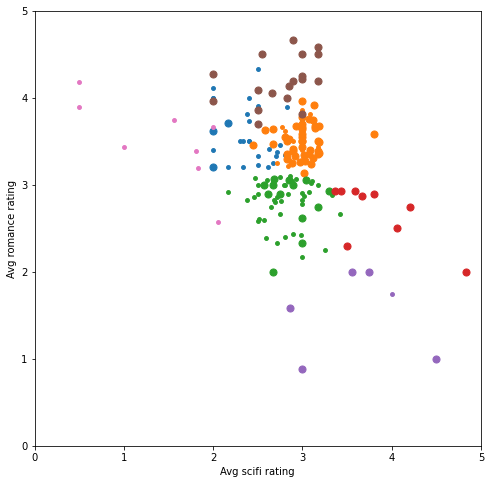

In [ ]:
# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)

# Use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)

# Define 3d plotting function
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    for g in clustered.group.unique():
            color = next(colors)
            for index, point in clustered[clustered.group == g].iterrows():
                if point['avg_action_rating'].astype(float) > 3: 
                    size = 50
                else:
                    size = 15
                plt.scatter(point['avg_scifi_rating'], 
                            point['avg_romance_rating'], 
                            s=size, 
                            color=color)
# Plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

## Movie-level Clustering

In [ ]:
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (671, 9064) 

Subset example:


title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN


The dominance of NaN values presents the first issue. Most users have not rated and watched most movies.

To get around this, sort by the most rated movies, and the users who have rated the most number of movies. That will present a more 'dense' region.

In [ ]:
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

In [ ]:
def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    # Get most voting users
    # 1- Count
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    # 2- Sort
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    # 3- Slice
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)
    
    return most_rated_movies_users_selection

In [ ]:
# Define the sorting by rating function
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies
    
# choose the number of movies and users and sort
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

# Print the result
print('dataset dimensions: ')
most_rated_movies_users_selection.head()

dataset dimensions: 


title,Forrest Gump (1994),Pulp Fiction (1994),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),"Matrix, The (1999)",Toy Story (1995),Schindler's List (1993),Terminator 2: Judgment Day (1991),Star Wars: Episode V - The Empire Strikes Back (1980),Braveheart (1995),Back to the Future (1985),Fargo (1996),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),American Beauty (1999),Independence Day (a.k.a. ID4) (1996),Star Wars: Episode VI - Return of the Jedi (1983),Aladdin (1992),"Fugitive, The (1993)",Dances with Wolves (1990),Fight Club (1999),"Usual Suspects, The (1995)",Seven (a.k.a. Se7en) (1995),"Lion King, The (1994)","Godfather, The (1972)","Lord of the Rings: The Fellowship of the Ring, The (2001)",Apollo 13 (1995),True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
29,5.0,5.0,5.0,4.0,4.0,4.0,3.0,4.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,3.0,5.0,3.0,5.0,4.0,2.0
508,4.0,5.0,4.0,4.0,5.0,3.0,4.5,3.0,5.0,2.0,5.0,5.0,3.0,4.5,5.0,4.5,2.0,4.0,3.5,4.0,5.0,4.0,5.0,4.0,3.5,5.0,4.5,3.0,2.0,4.0
14,1.0,5.0,2.0,5.0,5.0,3.0,5.0,2.0,4.0,4.0,5.0,3.0,5.0,5.0,4.0,4.0,2.5,5.0,0.5,5.0,3.0,5.0,5.0,5.0,4.0,5.0,5.0,3.0,4.0,4.0
72,5.0,5.0,5.0,4.5,4.5,4.0,4.5,5.0,5.0,3.0,5.0,4.0,5.0,4.0,5.0,4.5,3.5,5.0,5.0,4.0,4.5,5.0,5.0,5.0,5.0,5.0,5.0,3.5,3.0,5.0
653,4.0,5.0,5.0,4.5,5.0,4.5,5.0,5.0,5.0,5.0,5.0,4.5,4.5,4.0,5.0,5.0,4.0,4.0,4.5,4.5,4.5,5.0,5.0,4.5,5.0,4.5,5.0,5.0,4.0,5.0


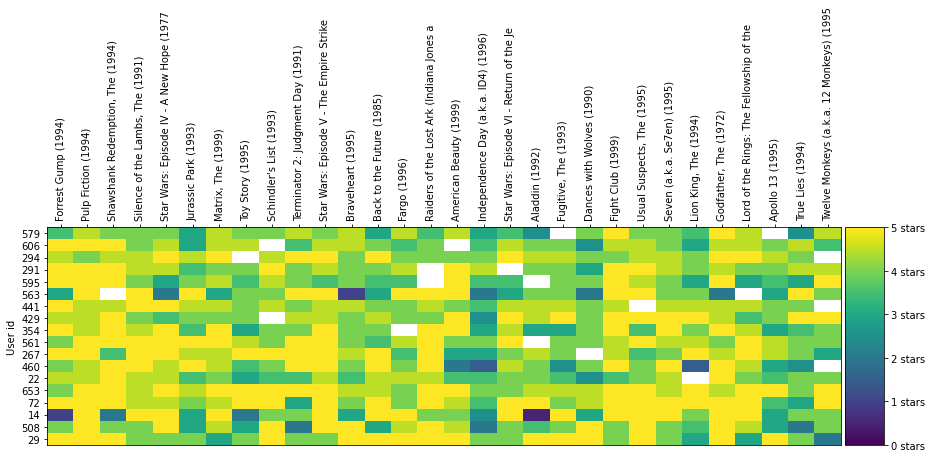

In [ ]:
# Define the plotting heatmap function
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    if axis_labels:
            ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
            ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
            ax.invert_yaxis()
            ax.xaxis.tick_top()
            labels = most_rated_movies_users_selection.columns.str[:40]
            ax.set_xticklabels(labels, minor=False)
            ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
            plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')
# Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
# Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
    plt.show()
# Print the heatmap


draw_movies_heatmap(most_rated_movies_users_selection)

Each column is a movie. Each row is a user. The color of the cell is how the user rated that movie based on the scale on the right of the graph.

For performance reasons, we'll only use ratings for 1000 movies (out of the 9000+ available in the dataset).

In [ ]:
# Define Function to get the most rated movies
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies
    
# Pivot the dataset and choose the first 1000 movies
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000)

In [ ]:
# Remove all nulls
tmpmovies=most_rated_movies_1k.copy()
tmpmovies=tmpmovies.fillna(0)
dtcols=most_rated_movies_1k.columns
tmpdict={}
for v in dtcols:
    tmpdict[v]=pd.arrays.SparseArray(tmpmovies[v])
sparseFrame=pd.DataFrame(tmpdict)
sparse_ratings = csr_matrix(sparseFrame)

In [ ]:
def draw_movie_clusters(clustered, max_users, max_movies):
    c=1
    for cluster_id in clustered.group.unique():
        # Show at most max_users users and max_movies movies per cluster.
        d = clustered[clustered.group == cluster_id].drop(['index', 'group'], axis=1)
        n_users_in_cluster = d.shape[0]
        
        d = sort_by_rating_density(d, max_movies, max_users)
        
        d = d.reindex(d.mean().sort_values(ascending=False).index, axis=1)
        d = d.reindex(d.count(axis=1).sort_values(ascending=False).index)
        d = d.iloc[:max_users, :max_movies]
        n_users_in_plot = d.shape[0]
        
        # Selecting to show clusters that have more than 9 users, otherwise, they're less interesting
        if len(d) > 9:
            print('cluster # {}'.format(cluster_id))
            print('# of users in cluster: {}.'.format(n_users_in_cluster), '# of users in plot: {}'.format(n_users_in_plot))
            fig = plt.figure(figsize=(15,4))
            ax = plt.gca()

            ax.invert_yaxis()
            ax.xaxis.tick_top()
            labels = d.columns.str[:40]

            ax.set_yticks(np.arange(d.shape[0]) , minor=False)
            ax.set_xticks(np.arange(d.shape[1]) , minor=False)

            ax.set_xticklabels(labels, minor=False)
                        
            ax.get_yaxis().set_visible(False)

            # Heatmap
            heatmap = plt.imshow(d, vmin=0, vmax=5, aspect='auto')

            ax.set_xlabel('movies')
            ax.set_ylabel('User id')

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)

            # Color bar
            cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
            cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])

            plt.setp(ax.get_xticklabels(), rotation=90, fontsize=9)
            plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', labelbottom='off', labelleft='off') 
            #print('cluster # {} \n(Showing at most {} users and {} movies)'.format(cluster_id, max_users, max_movies))

            plt.show()

cluster # 17
# of users in cluster: 275. # of users in plot: 70


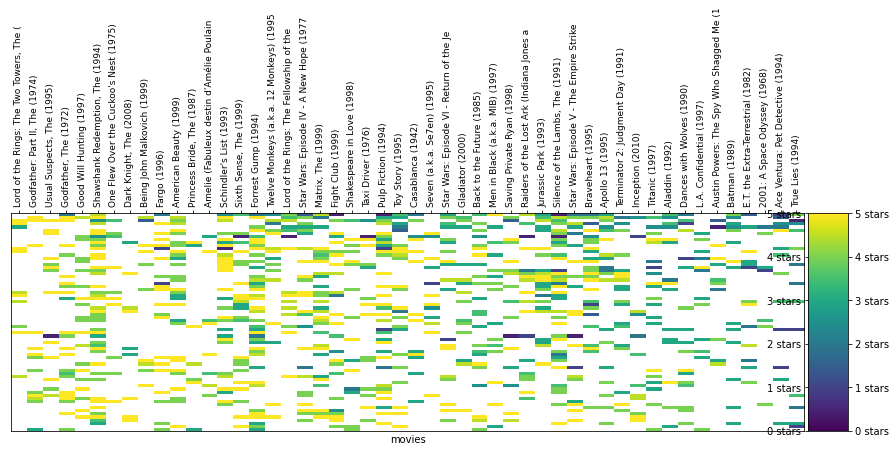

cluster # 16
# of users in cluster: 82. # of users in plot: 70


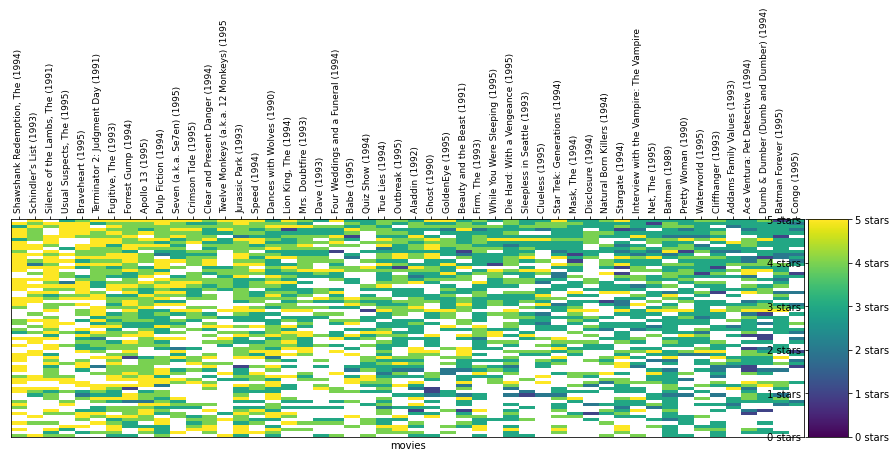

cluster # 0
# of users in cluster: 16. # of users in plot: 16


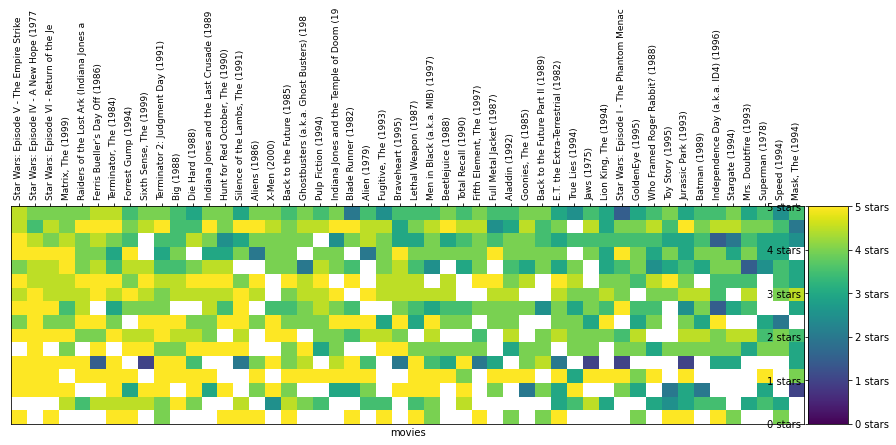

cluster # 10
# of users in cluster: 62. # of users in plot: 62


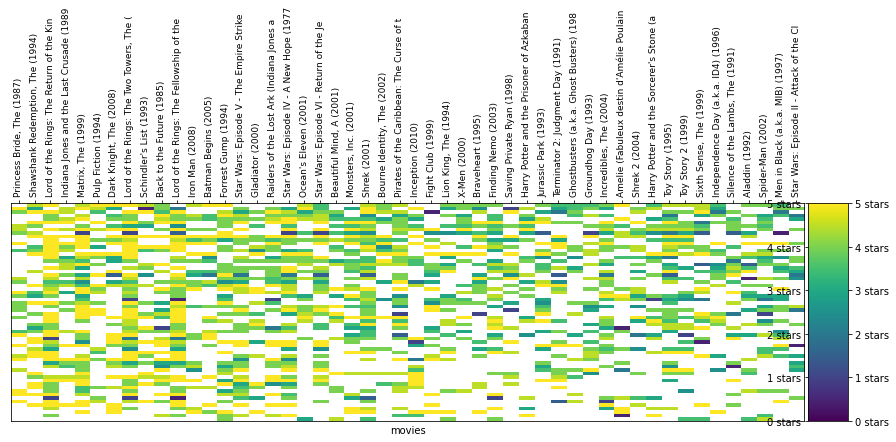

cluster # 2
# of users in cluster: 43. # of users in plot: 43


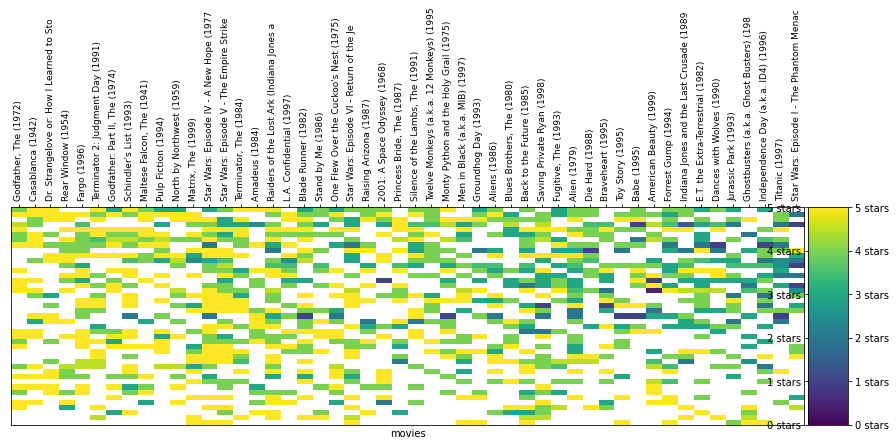

cluster # 1
# of users in cluster: 46. # of users in plot: 46


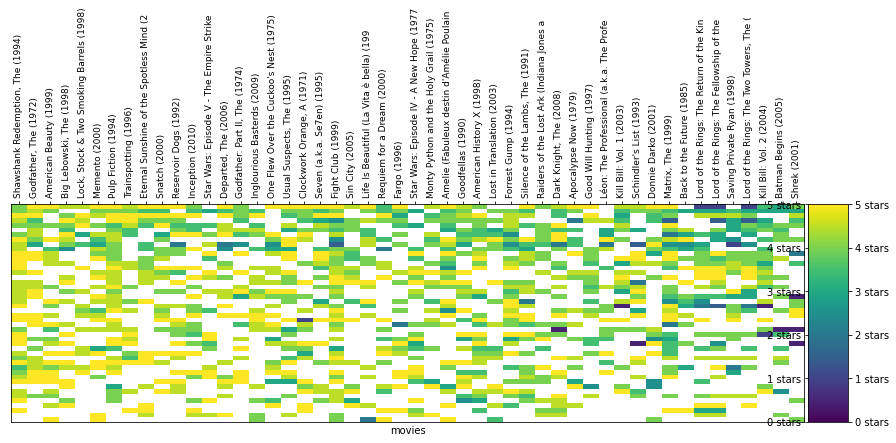

cluster # 6
# of users in cluster: 36. # of users in plot: 36


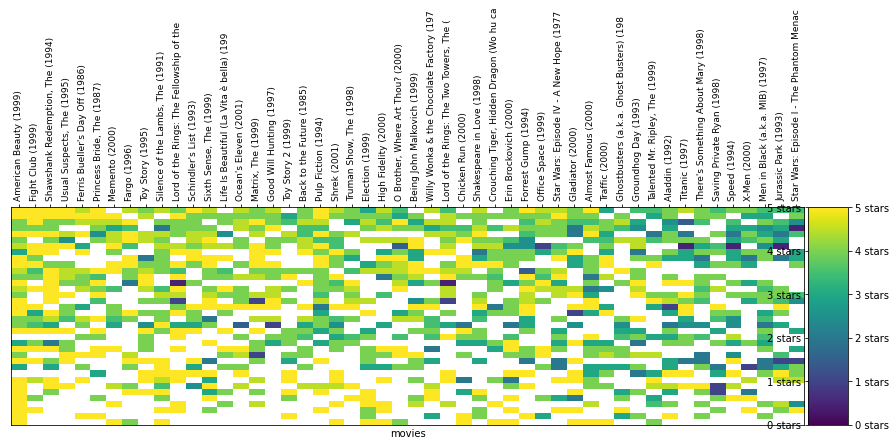

cluster # 7
# of users in cluster: 36. # of users in plot: 36


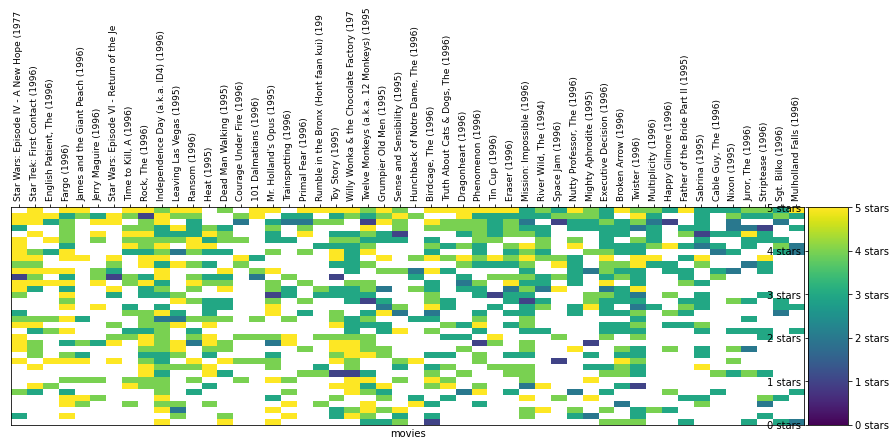

cluster # 18
# of users in cluster: 28. # of users in plot: 28


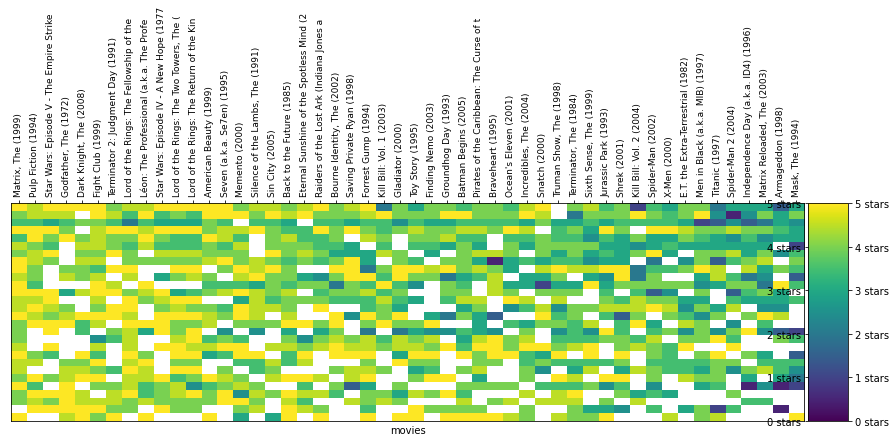

cluster # 12
# of users in cluster: 11. # of users in plot: 11


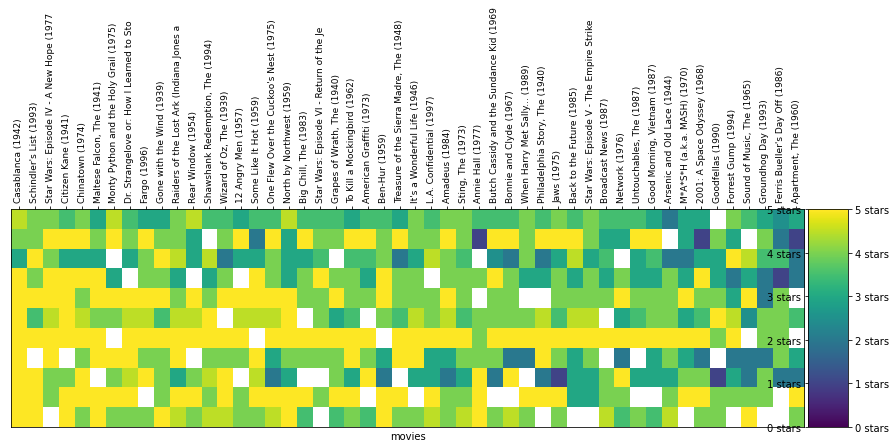

In [ ]:
# 20 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)

# Select the mas number of users and movies heatmap cluster
max_users = 70
max_movies = 50

# Cluster and print some of them
clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
draw_movie_clusters(clustered, max_users, max_movies)

There are several things to note here:
* The more similar the ratings in a cluster are, the more **vertical** lines in similar colors you'll be able to trace in that cluster. 
 * Some clusters are more sparse than others, containing people who probably watch and rate less movies than in other clusters.
 * Some clusters are mostly yellow and bring together people who really love a certain group of movies. Other clusters are mostly green or navy blue meaning they contain people who agree that a certain set of movoies deserves 2-3 stars.
 * Note how the movies change in every cluster. The graph filters the data to only show the most rated movies, and then sorts them by average rating.
 * Can you track where the Lord of the Rings movies appear in each cluster? What about Star Wars movies?
* It's easy to spot **horizontal** lines with similar colors, these are users without a lot of variety in their ratings.

## Prediction

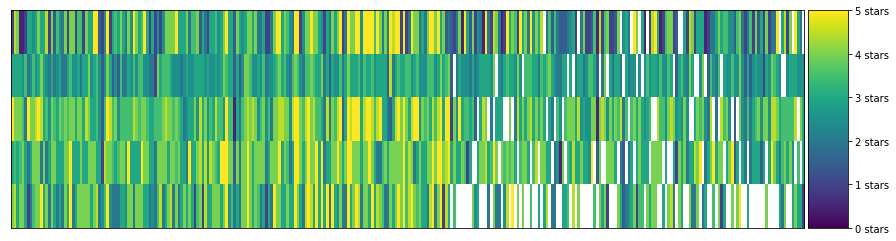

In [ ]:
# Pick a cluster ID from the clusters above
cluster_number = 11

# Let's filter to only see the region of the dataset with the most number of values 
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)

# Sort and print the cluster
cluster = sort_by_rating_density(cluster, n_movies, n_users)
draw_movies_heatmap(cluster, axis_labels=False)

In [ ]:
# Print the ratings
cluster.fillna('').head()

,Forrest Gump (1994),Batman Begins (2005),Beetlejuice (1988),Kill Bill: Vol. 2 (2004),Road to Perdition (2002),Chicken Run (2000),"Fast and the Furious, The (2001)",Back to the Future Part II (1989),Catch Me If You Can (2002),As Good as It Gets (1997),Indiana Jones and the Temple of Doom (1984),"O Brother, Where Art Thou? (2000)",Cast Away (2000),Get Shorty (1995),Happy Gilmore (1996),Donnie Darko (2001),Risky Business (1983),Ghostbusters II (1989),Grease (1978),Hook (1991),Quiz Show (1994),Billy Elliot (2000),"Player, The (1992)",Total Recall (1990),Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),Rain Man (1988),Jerry Maguire (1996),Master and Commander: The Far Side of the World (2003),"Breakfast Club, The (1985)","Wizard of Oz, The (1939)",Clear and Present Danger (1994),Minority Report (2002),"Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)","Saint, The (1997)",Lara Croft: Tomb Raider (2001),Gangs of New York (2002),Apocalypse Now (1979),Kill Bill: Vol. 1 (2003),American Pie (1999),Weird Science (1985),...,Bill & Ted's Excellent Adventure (1989),Blue Velvet (1986),Bend It Like Beckham (2002),Wild Wild West (1999),Bambi (1942),City Slickers (1991),Zoolander (2001),Crimes and Misdemeanors (1989),Gremlins (1984),Say Anything... (1989),"Fly, The (1986)","Knight's Tale, A (2001)",Cool Hand Luke (1967),Legally Blonde (2001),Fletch (1985),"Deer Hunter, The (1978)",Deep Impact (1998),Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (2002),"Others, The (2001)",Mr. & Mrs. Smith (2005),Phone Booth (2002),Three Kings (1999),"Life Aquatic with Steve Zissou, The (2004)",Planet of the Apes (2001),Billy Madison (1995),Adaptation (2002),I Am Legend (2007),Toy Story 3 (2010),"Social Network, The (2010)",Tootsie (1982),"Last of the Mohicans, The (1992)",Mallrats (1995),Sideways (2004),"Hangover, The (2009)",Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan (2006),Fear and Loathing in Las Vegas (1998),"Insider, The (1999)",Super Size Me (2004),Chocolat (2000),Little Shop of Horrors (1986)
0,1.0,4.5,4.0,0.5,0.5,1.0,3.0,3.0,2.5,3.0,4.0,3.0,3.0,4.5,1.0,4.0,1.5,3.5,2.5,2.0,4.0,1.0,4.0,4.0,1.0,3.5,3.5,1.0,4.0,3.0,3.0,5.0,5.0,1.5,1.0,2.5,5.0,1.0,3.0,3.5,...,3,3,0.5,1,2,2,3,4,3,3.5,3.5,2.5,2.5,1.5,3.5,4,2,1,2,3.5,1,4,1.5,3,1,4,1,2,2,5,,3,4.5,1,4,,5,3,2,
2,3.0,3.0,3.0,3.0,2.5,3.5,2.0,2.5,3.5,2.5,3.0,4.0,3.0,2.5,2.0,3.0,2.0,2.5,3.0,2.0,2.0,3.0,3.5,2.5,2.5,3.0,2.0,3.0,3.0,4.0,2.5,3.0,3.5,2.5,1.5,2.5,4.0,3.0,1.5,2.5,...,2.5,4,,1.5,3.5,2.5,2,3.5,,3,2.5,2.5,3.5,2.5,2.5,4,2.5,1.5,3,1.5,2.5,3,2.5,2.5,1,3,2.5,4,3.5,3,2.5,,,2.5,3,3,3,2.5,2.5,2.5
1,5.0,4.0,4.0,4.0,3.5,2.0,5.0,4.0,4.0,4.5,5.0,4.5,3.0,3.5,2.5,4.0,3.5,3.0,4.0,3.5,4.0,3.5,4.0,4.0,3.0,4.0,4.0,3.0,4.5,4.0,3.0,3.0,3.5,2.5,1.5,3.5,5.0,4.5,3.5,4.0,...,3.5,4,2.5,2,4.5,,2,,4.5,3.5,4,2.5,,1.5,,4,2.5,2,3.5,2,3,3.5,4,2.5,4,4,2.5,4.5,4.5,4,3,3.5,3.5,3.5,3.5,3.5,4.5,,4,3
4,3.0,3.5,3.0,3.5,4.0,3.0,2.0,3.0,4.0,4.0,4.0,2.0,4.0,2.0,3.0,4.0,4.0,3.0,3.0,3.0,4.0,4.0,5.0,3.0,3.0,3.0,4.0,3.0,3.0,4.0,4.0,4.0,3.0,3.0,1.0,4.5,4.0,4.0,3.5,3.0,...,5,,2,3,4,5,3,4,4,,3,4,5,1.5,3,,3,2,,2,3,3,3,1.5,3,,3,5,4,3,2,3.5,4,3,4,2.5,,3.5,,3
3,4.0,4.5,3.0,4.0,4.0,3.0,1.0,2.0,3.5,4.0,4.0,5.0,3.0,4.0,2.0,4.0,3.0,2.0,3.0,2.0,4.0,3.0,5.0,2.0,3.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4.5,2.0,2.5,3.5,5.0,2.5,2.0,2.0,...,,2,3,,,3.5,,4,1,3,,,4,,4,5,,,3,,,,,,,4,,,,,3,2,4,,,3,4,3,3,1


In [ ]:
# Fill in the name of the column/movie. e.g. 'Forrest Gump (1994)'
movie_name = "Back to the Future Part II (1989)"
cluster[movie_name].mean()

3.0

## Recommendation

In [ ]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

Forrest Gump (1994)                            3.2
Batman Begins (2005)                           3.9
Beetlejuice (1988)                             3.4
Kill Bill: Vol. 2 (2004)                       3.0
Road to Perdition (2002)                       2.9
Chicken Run (2000)                             2.5
Fast and the Furious, The (2001)               2.6
Back to the Future Part II (1989)              2.9
Catch Me If You Can (2002)                     3.5
As Good as It Gets (1997)                      3.6
Indiana Jones and the Temple of Doom (1984)    4.0
O Brother, Where Art Thou? (2000)              3.7
Cast Away (2000)                               3.2
Get Shorty (1995)                              3.3
Happy Gilmore (1996)                           2.1
Donnie Darko (2001)                            3.8
Risky Business (1983)                          2.8
Ghostbusters II (1989)                         2.8
Grease (1978)                                  3.1
Hook (1991)                    

In [ ]:
# Pick a user ID from the dataset
user_id = 2

# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]

# Which movies did they not rate? 
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]

# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]

# Let's sort by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending=False)[:20]

Black Hawk Down (2001)                       4.125
Sideways (2004)                              4.000
Scarface (1983)                              4.000
Wallace & Gromit: A Close Shave (1995)       3.750
Rounders (1998)                              3.750
Bowfinger (1999)                             3.250
Garden State (2004)                          3.250
25th Hour (2002)                             3.125
Collateral (2004)                            3.125
Gremlins (1984)                              3.125
Mallrats (1995)                              3.000
Road Trip (2000)                             2.875
American Pie 2 (2001)                        2.750
Jay and Silent Bob Strike Back (2001)        2.625
Man on the Moon (1999)                       2.500
Bend It Like Beckham (2002)                  2.000
Terminator 3: Rise of the Machines (2003)    1.875
Name: 0, dtype: float64